# 1. Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

In [2]:
# Import data

def import_data(dir, norm=True):
    dfs = []
    min_val,max_val = (None,None)
    for file in os.listdir(dir):
        df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        df = df.drop(columns=[0])
        dfs.append(df)
        min_val = min(df.values.min(), min_val) if min_val else df.values.min()
        max_val = max(df.values.max(), max_val) if max_val else df.values.max()
    for i,df in enumerate(dfs):
        dfs[i] = (df-min_val)/(max_val-min_val)
        
    return dfs, min_val, max_val

train_dfs, train_min, train_max = import_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs, test_min, test_max = import_data("/Users/faith/Desktop/Projects/tsad/data/test")

In [3]:
# Convert to Tensors

train = torch.FloatTensor(train_dfs[0].values)
test = torch.FloatTensor(test_dfs[0].values)

In [4]:
# Assign time windows + target

def reshape_tensor(df, time_window):
    n,k = df.shape
    num_windows = n//time_window
    return df[:num_windows*time_window].reshape([num_windows, time_window,k])


def get_targets(df, time_window):
    n,k = df.shape
    idxs = np.arange(time_window,n,time_window)
    return df[idxs]

time_window = 100
train_windows = reshape_tensor(train,time_window)[:-1] # delete last window (no label)
train_targets = get_targets(train,time_window)


In [5]:
train.shape, train_windows.shape, train_targets.shape

(torch.Size([86400, 32]), torch.Size([863, 100, 32]), torch.Size([863, 32]))

In [6]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, windows, window_labels):
        self.windows = windows
        self.window_labels = window_labels
        
    def __len__(self):
        return self.windows.shape[0]
    
    def __getitem__(self,i):
        return self.windows[i], self.window_labels[i]
    
train_dataset = TimewindowDataset(train_windows, train_targets)
train_dataloader = DataLoader(train_dataset)

# 2. Model

In [8]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, n, k, hidden_dim=256):
        """
        n = number timesteps
        k = number sensors
        """
        super().__init__()
               
        self.fc1 = nn.Linear(n, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x
    

# 3. Training

In [13]:
num_windows,n,k = train_windows.shape
learn_rate=1e-3
EPOCHS = 200
model = GATModel(n,k)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
for epoch in range(0,EPOCHS):
    for i,item in enumerate(train_dataloader):
        window, target = item
        window = window.squeeze()
        target = target.T.squeeze()
        for sensor in range(window.shape[1]):
            x = model(window[:,sensor])
            model.zero_grad()     
            loss = criterion(x,target[sensor])
            loss.backward()
            optimizer.step()
            if i%500 == 0 and epoch%2 == 0:
                print(f"Epoch {epoch}, item {i}, loss {loss.item()}")


Epoch 0, item 0, loss 0.06316084414720535
Epoch 0, item 0, loss 0.012480605393648148
Epoch 0, item 0, loss 0.000592698052059859
Epoch 0, item 0, loss 0.00142134097404778
Epoch 0, item 0, loss 0.001251434558071196
Epoch 0, item 0, loss 0.00222165510058403
Epoch 0, item 0, loss 0.002553989179432392
Epoch 0, item 0, loss 0.002181344199925661
Epoch 0, item 0, loss 0.00207402347587049
Epoch 0, item 0, loss 0.0017728708917275071
Epoch 0, item 0, loss 0.001176593010313809
Epoch 0, item 0, loss 0.000745918252505362
Epoch 0, item 0, loss 0.000785297539550811
Epoch 0, item 0, loss 0.00013909634435549378
Epoch 0, item 0, loss 1.1692367479554377e-05
Epoch 0, item 0, loss 6.244678661460057e-05
Epoch 0, item 0, loss 6.775744259357452e-05
Epoch 0, item 0, loss 0.0003725598508026451
Epoch 0, item 0, loss 0.000591983029153198
Epoch 0, item 0, loss 0.0006505423807539046
Epoch 0, item 0, loss 0.0005980667774565518
Epoch 0, item 0, loss 0.0004886566894128919
Epoch 0, item 0, loss 0.0007602401892654598
Epo

Epoch 6, item 0, loss 3.7674633404094493e-06
Epoch 6, item 0, loss 4.112978757575547e-08
Epoch 6, item 0, loss 2.0890006169338449e-07
Epoch 6, item 0, loss 6.363908937601082e-07
Epoch 6, item 0, loss 2.7737087293644436e-07
Epoch 6, item 0, loss 2.402547352176043e-07
Epoch 6, item 0, loss 7.65716112738346e-09
Epoch 6, item 0, loss 6.939546182138656e-08
Epoch 6, item 0, loss 1.2158534445916303e-07
Epoch 6, item 0, loss 1.2765583790042e-07
Epoch 6, item 0, loss 1.4927952918242227e-07
Epoch 6, item 0, loss 7.454602979350966e-08
Epoch 6, item 0, loss 3.9889110325930233e-07
Epoch 6, item 0, loss 3.360303537647269e-07
Epoch 6, item 0, loss 3.3977229918491503e-07
Epoch 6, item 0, loss 2.9677605084543757e-07
Epoch 6, item 0, loss 6.545310071714994e-08
Epoch 6, item 0, loss 8.348688140813465e-08
Epoch 6, item 0, loss 2.1528200022657984e-07
Epoch 6, item 0, loss 1.3854361213816446e-06
Epoch 6, item 0, loss 1.0484306045555059e-07
Epoch 6, item 0, loss 8.473907797679203e-08
Epoch 6, item 0, loss 4.

Epoch 12, item 0, loss 4.199801878712606e-06
Epoch 12, item 0, loss 1.2695088003056298e-07
Epoch 12, item 0, loss 2.1890966195314832e-07
Epoch 12, item 0, loss 5.585139888353297e-07
Epoch 12, item 0, loss 2.498687763363705e-07
Epoch 12, item 0, loss 1.9347839952388313e-07
Epoch 12, item 0, loss 2.205732307913877e-08
Epoch 12, item 0, loss 1.6733859808937268e-07
Epoch 12, item 0, loss 2.6096677174791694e-07
Epoch 12, item 0, loss 2.2744984562450554e-07
Epoch 12, item 0, loss 2.3565947060433245e-07
Epoch 12, item 0, loss 1.9534927275799419e-07
Epoch 12, item 0, loss 6.56807969789952e-07
Epoch 12, item 0, loss 5.463588763632288e-07
Epoch 12, item 0, loss 5.296639642438095e-07
Epoch 12, item 0, loss 4.4493646100818296e-07
Epoch 12, item 0, loss 1.0827402974200595e-08
Epoch 12, item 0, loss 1.3551107258535922e-07
Epoch 12, item 0, loss 2.5723497287799546e-07
Epoch 12, item 0, loss 1.2993989457754651e-06
Epoch 12, item 0, loss 1.0130183625278733e-07
Epoch 12, item 0, loss 7.05117884081119e-0

KeyboardInterrupt: 

In [35]:
PATH = "ffn.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [30]:
test = torch.FloatTensor(test_dfs[1].values)
test_windows = reshape_tensor(test,time_window)[:-1]
test_targets = get_targets(test,time_window)
#prev_h = h
# test_dfs, test_min
test_windows.shape

torch.Size([863, 100, 32])

In [31]:
pred.shape

(863, 32)

In [34]:
model.eval()
pred = np.zeros(train_targets.shape)
for i,window in enumerate(test_windows):
    for sensor in range(window.shape[1]):
        x = model(window[:,sensor])
        print(x)
        pred[i][sensor] = x.detach().numpy().reshape(-1)


tensor([0.1732], grad_fn=<AddBackward0>)
tensor([0.0894], grad_fn=<AddBackward0>)
tensor([0.0251], grad_fn=<AddBackward0>)
tensor([0.0929], grad_fn=<AddBackward0>)
tensor([0.0093], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0336], grad_fn=<AddBackward0>)
tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0057], grad_fn=<AddBackward0>)
tensor([0.0174], grad_fn=<AddBackward0>)
tensor([0.0673], grad_fn=<AddBackward0>)
tensor([0.0361], grad_fn=<AddBackward0>)
tensor([0.0445], grad_fn=<AddBackward0>)
tensor([0.0346], grad_fn=<AddBackward0>)
tensor([0.1295], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0246], grad_fn=<AddBackward0>)
tensor([0.0154], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.0181], grad_fn=<AddBackward0>)
tensor([0.9543], grad_fn=<AddBackward0>)
tensor([0.6912], grad_fn=<AddBackward0>)
tensor([0.0258],

tensor([0.6815], grad_fn=<AddBackward0>)
tensor([0.0263], grad_fn=<AddBackward0>)
tensor([0.0031], grad_fn=<AddBackward0>)
tensor([0.0161], grad_fn=<AddBackward0>)
tensor([0.0165], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0018], grad_fn=<AddBackward0>)
tensor([0.6456], grad_fn=<AddBackward0>)
tensor([0.1026], grad_fn=<AddBackward0>)
tensor([0.1700], grad_fn=<AddBackward0>)
tensor([0.0894], grad_fn=<AddBackward0>)
tensor([0.0252], grad_fn=<AddBackward0>)
tensor([0.0938], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0089], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0336], grad_fn=<AddBackward0>)
tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0057], grad_fn=<AddBackward0>)
tensor([0.0166], grad_fn=<AddBackward0>)
tensor([0.0676], grad_fn=<AddBackward0>)
tensor([0.0361], grad_fn=<AddBackward0>)
tensor([0.0450], grad_fn=<AddBackward0>)
tensor([0.0347],

tensor([0.0086], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0331], grad_fn=<AddBackward0>)
tensor([0.0344], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0058], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.0657], grad_fn=<AddBackward0>)
tensor([0.0359], grad_fn=<AddBackward0>)
tensor([0.0424], grad_fn=<AddBackward0>)
tensor([0.0344], grad_fn=<AddBackward0>)
tensor([0.1260], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0241], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0181], grad_fn=<AddBackward0>)
tensor([0.0180], grad_fn=<AddBackward0>)
tensor([0.9409], grad_fn=<AddBackward0>)
tensor([0.6887], grad_fn=<AddBackward0>)
tensor([0.0260], grad_fn=<AddBackward0>)
tensor([0.0041], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0025],

tensor([0.0438], grad_fn=<AddBackward0>)
tensor([0.0345], grad_fn=<AddBackward0>)
tensor([0.1276], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0244], grad_fn=<AddBackward0>)
tensor([0.0151], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.0181], grad_fn=<AddBackward0>)
tensor([0.9285], grad_fn=<AddBackward0>)
tensor([0.6875], grad_fn=<AddBackward0>)
tensor([0.0260], grad_fn=<AddBackward0>)
tensor([0.0050], grad_fn=<AddBackward0>)
tensor([0.0145], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0025], grad_fn=<AddBackward0>)
tensor([0.6441], grad_fn=<AddBackward0>)
tensor([0.1039], grad_fn=<AddBackward0>)
tensor([0.1638], grad_fn=<AddBackward0>)
tensor([0.0924], grad_fn=<AddBackward0>)
tensor([0.0249], grad_fn=<AddBackward0>)
tensor([0.0974], grad_fn=<AddBackward0>)
tensor([0.0086], grad_fn=<AddBackward0>)
tensor([0.0083], grad_fn=<AddBackward0>)
tensor([0.0121],

tensor([0.0650], grad_fn=<AddBackward0>)
tensor([0.0358], grad_fn=<AddBackward0>)
tensor([0.0432], grad_fn=<AddBackward0>)
tensor([0.0345], grad_fn=<AddBackward0>)
tensor([0.1281], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0244], grad_fn=<AddBackward0>)
tensor([0.0151], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.0181], grad_fn=<AddBackward0>)
tensor([0.9516], grad_fn=<AddBackward0>)
tensor([0.6883], grad_fn=<AddBackward0>)
tensor([0.0261], grad_fn=<AddBackward0>)
tensor([0.0037], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0019], grad_fn=<AddBackward0>)
tensor([0.6472], grad_fn=<AddBackward0>)
tensor([0.1029], grad_fn=<AddBackward0>)
tensor([0.1638], grad_fn=<AddBackward0>)
tensor([0.0910], grad_fn=<AddBackward0>)
tensor([0.0252], grad_fn=<AddBackward0>)
tensor([0.0965], grad_fn=<AddBackward0>)
tensor([0.0087],

tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0245], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0188], grad_fn=<AddBackward0>)
tensor([0.0188], grad_fn=<AddBackward0>)
tensor([0.9392], grad_fn=<AddBackward0>)
tensor([0.6893], grad_fn=<AddBackward0>)
tensor([0.0260], grad_fn=<AddBackward0>)
tensor([0.0046], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0022], grad_fn=<AddBackward0>)
tensor([0.6464], grad_fn=<AddBackward0>)
tensor([0.1042], grad_fn=<AddBackward0>)
tensor([0.1733], grad_fn=<AddBackward0>)
tensor([0.0889], grad_fn=<AddBackward0>)
tensor([0.0251], grad_fn=<AddBackward0>)
tensor([0.0915], grad_fn=<AddBackward0>)
tensor([0.0094], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0337], grad_fn=<AddBackward0>)
tensor([0.0351], grad_fn=<AddBackward0>)
tensor([0.0021],

tensor([0.0094], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0336], grad_fn=<AddBackward0>)
tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0057], grad_fn=<AddBackward0>)
tensor([0.0177], grad_fn=<AddBackward0>)
tensor([0.0656], grad_fn=<AddBackward0>)
tensor([0.0359], grad_fn=<AddBackward0>)
tensor([0.0433], grad_fn=<AddBackward0>)
tensor([0.0345], grad_fn=<AddBackward0>)
tensor([0.1290], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0243], grad_fn=<AddBackward0>)
tensor([0.0143], grad_fn=<AddBackward0>)
tensor([0.0183], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.9337], grad_fn=<AddBackward0>)
tensor([0.6876], grad_fn=<AddBackward0>)
tensor([0.0257], grad_fn=<AddBackward0>)
tensor([0.0049], grad_fn=<AddBackward0>)
tensor([0.0152], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121],

tensor([0.0088], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0334], grad_fn=<AddBackward0>)
tensor([0.0347], grad_fn=<AddBackward0>)
tensor([0.0020], grad_fn=<AddBackward0>)
tensor([0.0057], grad_fn=<AddBackward0>)
tensor([0.0177], grad_fn=<AddBackward0>)
tensor([0.0651], grad_fn=<AddBackward0>)
tensor([0.0359], grad_fn=<AddBackward0>)
tensor([0.0427], grad_fn=<AddBackward0>)
tensor([0.0344], grad_fn=<AddBackward0>)
tensor([0.1277], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0245], grad_fn=<AddBackward0>)
tensor([0.0150], grad_fn=<AddBackward0>)
tensor([0.0182], grad_fn=<AddBackward0>)
tensor([0.0181], grad_fn=<AddBackward0>)
tensor([0.9483], grad_fn=<AddBackward0>)
tensor([0.6864], grad_fn=<AddBackward0>)
tensor([0.0258], grad_fn=<AddBackward0>)
tensor([0.0042], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0025],

tensor([0.1286], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0245], grad_fn=<AddBackward0>)
tensor([0.0129], grad_fn=<AddBackward0>)
tensor([0.0186], grad_fn=<AddBackward0>)
tensor([0.0185], grad_fn=<AddBackward0>)
tensor([0.9428], grad_fn=<AddBackward0>)
tensor([0.6851], grad_fn=<AddBackward0>)
tensor([0.0260], grad_fn=<AddBackward0>)
tensor([0.0041], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0023], grad_fn=<AddBackward0>)
tensor([0.6461], grad_fn=<AddBackward0>)
tensor([0.1034], grad_fn=<AddBackward0>)
tensor([0.1705], grad_fn=<AddBackward0>)
tensor([0.0879], grad_fn=<AddBackward0>)
tensor([0.0252], grad_fn=<AddBackward0>)
tensor([0.0940], grad_fn=<AddBackward0>)
tensor([0.0092], grad_fn=<AddBackward0>)
tensor([0.0090], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0333], grad_fn=<AddBackward0>)
tensor([0.0345],

tensor([0.0337], grad_fn=<AddBackward0>)
tensor([0.0350], grad_fn=<AddBackward0>)
tensor([0.0018], grad_fn=<AddBackward0>)
tensor([0.0055], grad_fn=<AddBackward0>)
tensor([0.0173], grad_fn=<AddBackward0>)
tensor([0.0663], grad_fn=<AddBackward0>)
tensor([0.0360], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0346], grad_fn=<AddBackward0>)
tensor([0.1308], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0242], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0191], grad_fn=<AddBackward0>)
tensor([0.0190], grad_fn=<AddBackward0>)
tensor([0.9439], grad_fn=<AddBackward0>)
tensor([0.6897], grad_fn=<AddBackward0>)
tensor([0.0257], grad_fn=<AddBackward0>)
tensor([0.0037], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0028], grad_fn=<AddBackward0>)
tensor([0.6508], grad_fn=<AddBackward0>)
tensor([0.1038],

tensor([0.0177], grad_fn=<AddBackward0>)
tensor([0.0176], grad_fn=<AddBackward0>)
tensor([0.9439], grad_fn=<AddBackward0>)
tensor([0.6822], grad_fn=<AddBackward0>)
tensor([0.0258], grad_fn=<AddBackward0>)
tensor([0.0041], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.6438], grad_fn=<AddBackward0>)
tensor([0.1030], grad_fn=<AddBackward0>)
tensor([0.1746], grad_fn=<AddBackward0>)
tensor([0.0864], grad_fn=<AddBackward0>)
tensor([0.0249], grad_fn=<AddBackward0>)
tensor([0.0941], grad_fn=<AddBackward0>)
tensor([0.0094], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0330], grad_fn=<AddBackward0>)
tensor([0.0342], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0066], grad_fn=<AddBackward0>)
tensor([0.0177], grad_fn=<AddBackward0>)
tensor([0.0626],

tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0020], grad_fn=<AddBackward0>)
tensor([0.0066], grad_fn=<AddBackward0>)
tensor([0.0171], grad_fn=<AddBackward0>)
tensor([0.0686], grad_fn=<AddBackward0>)
tensor([0.0362], grad_fn=<AddBackward0>)
tensor([0.0454], grad_fn=<AddBackward0>)
tensor([0.0347], grad_fn=<AddBackward0>)
tensor([0.1295], grad_fn=<AddBackward0>)
tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0244], grad_fn=<AddBackward0>)
tensor([0.0132], grad_fn=<AddBackward0>)
tensor([0.0185], grad_fn=<AddBackward0>)
tensor([0.0185], grad_fn=<AddBackward0>)
tensor([0.8923], grad_fn=<AddBackward0>)
tensor([0.6985], grad_fn=<AddBackward0>)
tensor([0.0258], grad_fn=<AddBackward0>)
tensor([0.0076], grad_fn=<AddBackward0>)
tensor([0.0104], grad_fn=<AddBackward0>)
tensor([0.0113], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0027], grad_fn=<AddBackward0>)
tensor([0.6490], grad_fn=<AddBackward0>)
tensor([0.1047], grad_fn=<AddBackward0>)
tensor([0.1705],

tensor([0.9320], grad_fn=<AddBackward0>)
tensor([0.6856], grad_fn=<AddBackward0>)
tensor([0.0259], grad_fn=<AddBackward0>)
tensor([0.0041], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0023], grad_fn=<AddBackward0>)
tensor([0.6464], grad_fn=<AddBackward0>)
tensor([0.1031], grad_fn=<AddBackward0>)
tensor([0.1665], grad_fn=<AddBackward0>)
tensor([0.0870], grad_fn=<AddBackward0>)
tensor([0.0254], grad_fn=<AddBackward0>)
tensor([0.0933], grad_fn=<AddBackward0>)
tensor([0.0091], grad_fn=<AddBackward0>)
tensor([0.0088], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0332], grad_fn=<AddBackward0>)
tensor([0.0343], grad_fn=<AddBackward0>)
tensor([0.0020], grad_fn=<AddBackward0>)
tensor([0.0064], grad_fn=<AddBackward0>)
tensor([0.0176], grad_fn=<AddBackward0>)
tensor([0.0681], grad_fn=<AddBackward0>)
tensor([0.0361], grad_fn=<AddBackward0>)
tensor([0.0442],

tensor([0.0247], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0192], grad_fn=<AddBackward0>)
tensor([0.0191], grad_fn=<AddBackward0>)
tensor([0.9325], grad_fn=<AddBackward0>)
tensor([0.6947], grad_fn=<AddBackward0>)
tensor([0.0257], grad_fn=<AddBackward0>)
tensor([0.0058], grad_fn=<AddBackward0>)
tensor([0.0125], grad_fn=<AddBackward0>)
tensor([0.0137], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0020], grad_fn=<AddBackward0>)
tensor([0.6511], grad_fn=<AddBackward0>)
tensor([0.1044], grad_fn=<AddBackward0>)
tensor([0.1800], grad_fn=<AddBackward0>)
tensor([0.0815], grad_fn=<AddBackward0>)
tensor([0.0250], grad_fn=<AddBackward0>)
tensor([0.0864], grad_fn=<AddBackward0>)
tensor([0.0103], grad_fn=<AddBackward0>)
tensor([0.0100], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0333], grad_fn=<AddBackward0>)
tensor([0.0348], grad_fn=<AddBackward0>)
tensor([0.0020], grad_fn=<AddBackward0>)
tensor([0.0063],

tensor([0.0442], grad_fn=<AddBackward0>)
tensor([0.0249], grad_fn=<AddBackward0>)
tensor([0.0117], grad_fn=<AddBackward0>)
tensor([0.0197], grad_fn=<AddBackward0>)
tensor([0.0196], grad_fn=<AddBackward0>)
tensor([0.9345], grad_fn=<AddBackward0>)
tensor([0.6954], grad_fn=<AddBackward0>)
tensor([0.0258], grad_fn=<AddBackward0>)
tensor([0.0063], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0125], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0018], grad_fn=<AddBackward0>)
tensor([0.6528], grad_fn=<AddBackward0>)
tensor([0.1033], grad_fn=<AddBackward0>)
tensor([0.1837], grad_fn=<AddBackward0>)
tensor([0.0818], grad_fn=<AddBackward0>)
tensor([0.0248], grad_fn=<AddBackward0>)
tensor([0.0851], grad_fn=<AddBackward0>)
tensor([0.0106], grad_fn=<AddBackward0>)
tensor([0.0103], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0335], grad_fn=<AddBackward0>)
tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0020],

tensor([0.9575], grad_fn=<AddBackward0>)
tensor([0.6908], grad_fn=<AddBackward0>)
tensor([0.0260], grad_fn=<AddBackward0>)
tensor([0.0038], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0159], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0016], grad_fn=<AddBackward0>)
tensor([0.6558], grad_fn=<AddBackward0>)
tensor([0.1035], grad_fn=<AddBackward0>)
tensor([0.1802], grad_fn=<AddBackward0>)
tensor([0.0827], grad_fn=<AddBackward0>)
tensor([0.0248], grad_fn=<AddBackward0>)
tensor([0.0867], grad_fn=<AddBackward0>)
tensor([0.0103], grad_fn=<AddBackward0>)
tensor([0.0100], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0335], grad_fn=<AddBackward0>)
tensor([0.0349], grad_fn=<AddBackward0>)
tensor([0.0021], grad_fn=<AddBackward0>)
tensor([0.0061], grad_fn=<AddBackward0>)
tensor([0.0157], grad_fn=<AddBackward0>)
tensor([0.0621], grad_fn=<AddBackward0>)
tensor([0.0356], grad_fn=<AddBackward0>)
tensor([0.0427],

tensor([0.0387], grad_fn=<AddBackward0>)
tensor([0.0338], grad_fn=<AddBackward0>)
tensor([0.1391], grad_fn=<AddBackward0>)
tensor([0.0441], grad_fn=<AddBackward0>)
tensor([0.0250], grad_fn=<AddBackward0>)
tensor([0.0076], grad_fn=<AddBackward0>)
tensor([0.0212], grad_fn=<AddBackward0>)
tensor([0.0211], grad_fn=<AddBackward0>)
tensor([0.9598], grad_fn=<AddBackward0>)
tensor([0.6825], grad_fn=<AddBackward0>)
tensor([0.0262], grad_fn=<AddBackward0>)
tensor([0.0033], grad_fn=<AddBackward0>)
tensor([0.0165], grad_fn=<AddBackward0>)
tensor([0.0166], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0009], grad_fn=<AddBackward0>)
tensor([0.6524], grad_fn=<AddBackward0>)
tensor([0.1011], grad_fn=<AddBackward0>)
tensor([0.1946], grad_fn=<AddBackward0>)
tensor([0.0723], grad_fn=<AddBackward0>)
tensor([0.0248], grad_fn=<AddBackward0>)
tensor([0.0726], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0121], grad_fn=<AddBackward0>)
tensor([0.0121],

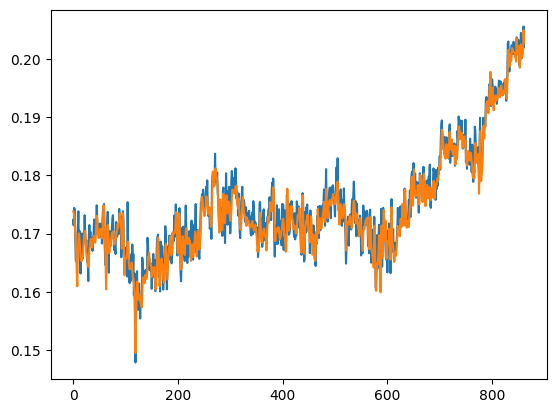

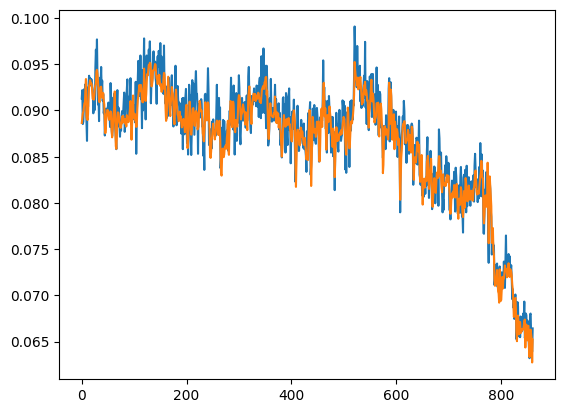

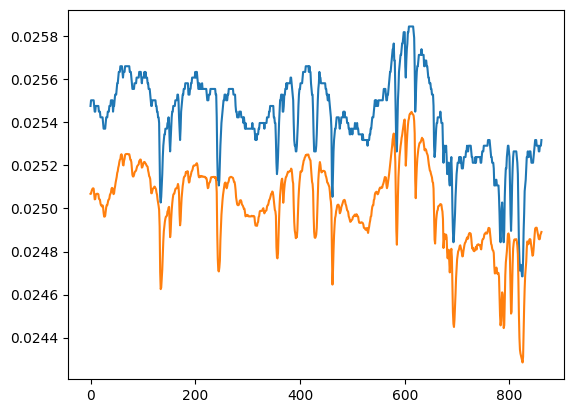

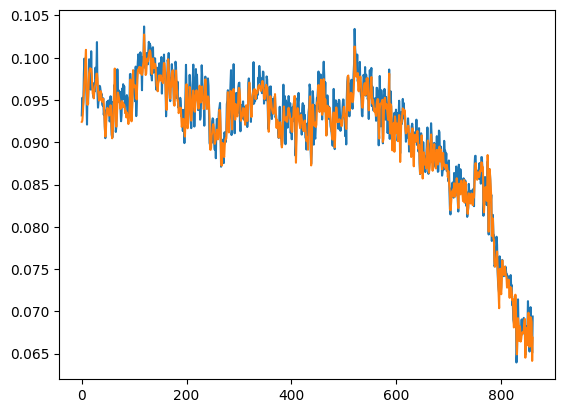

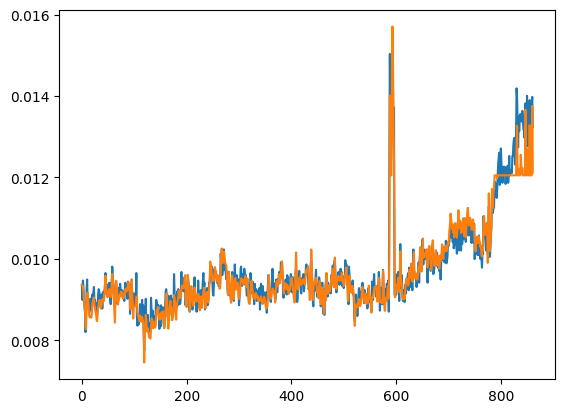

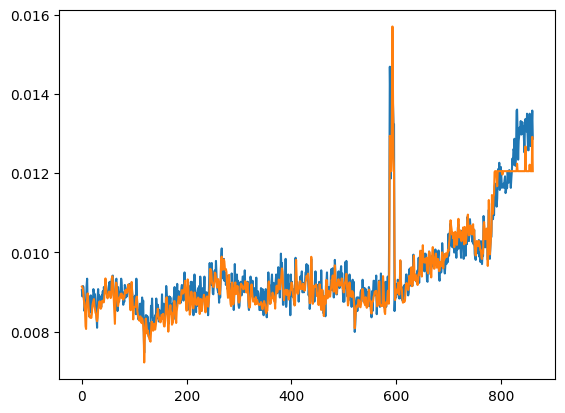

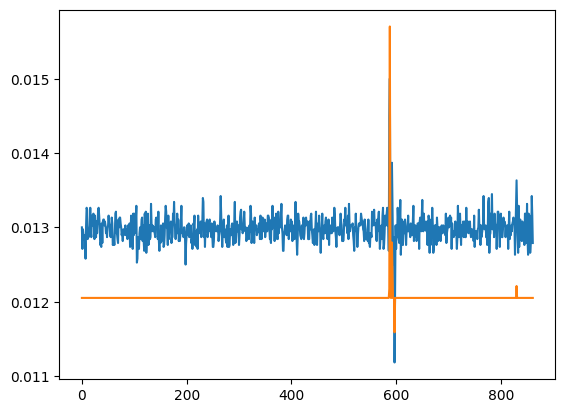

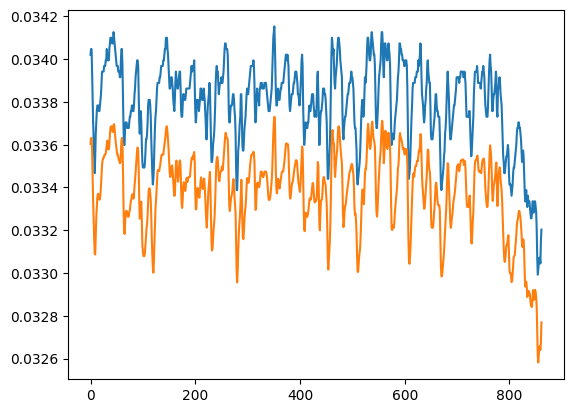

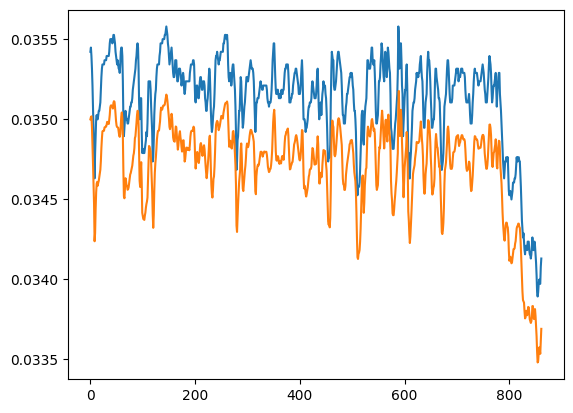

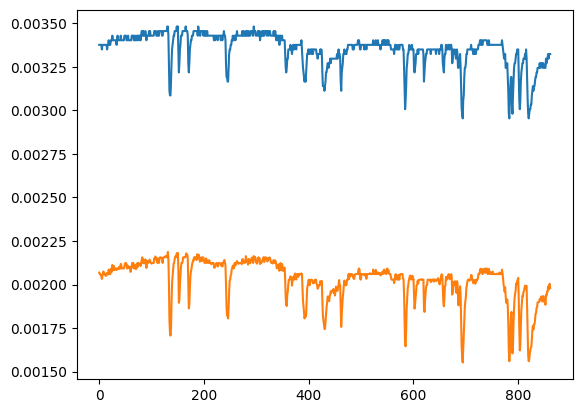

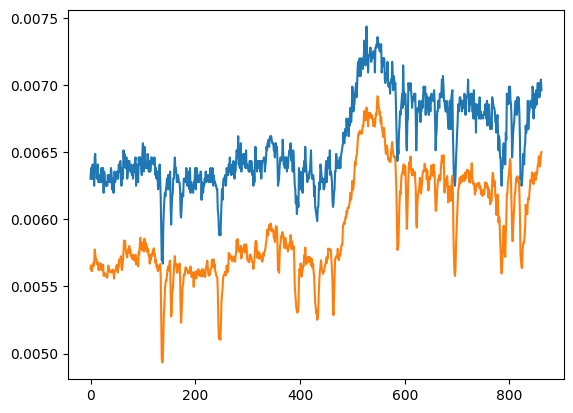

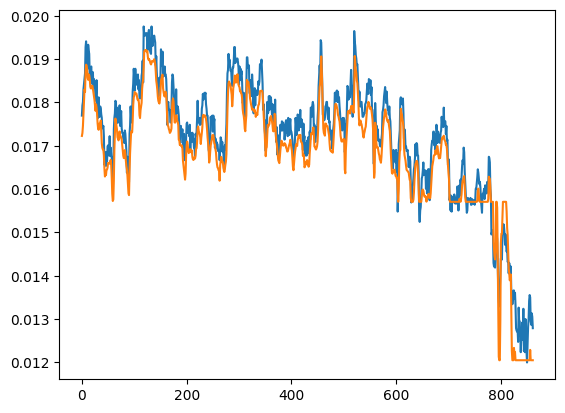

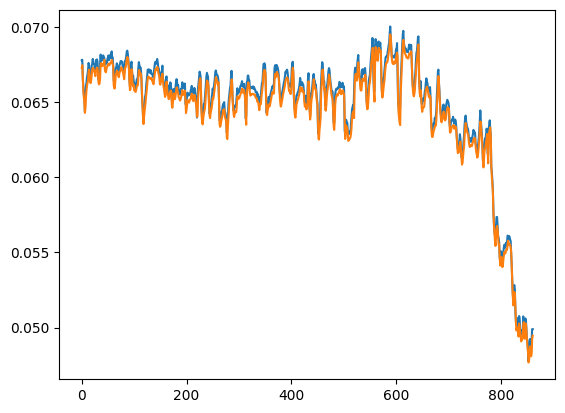

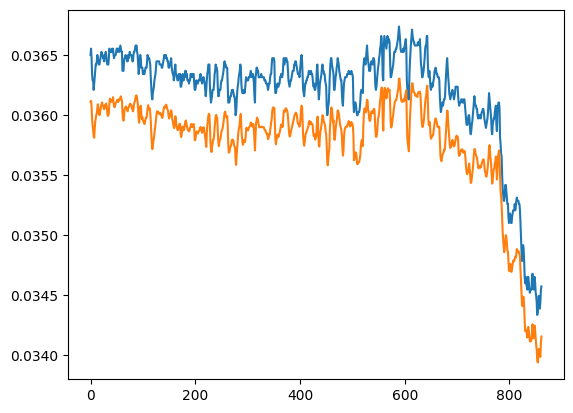

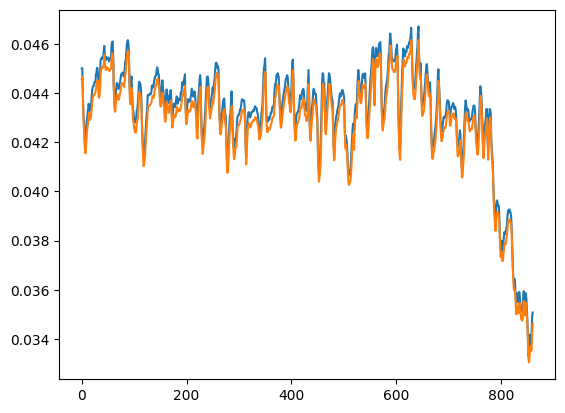

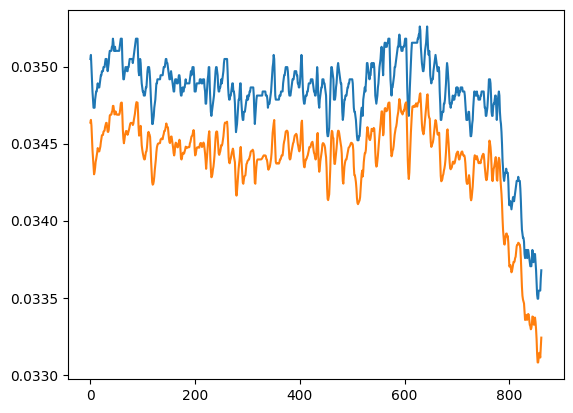

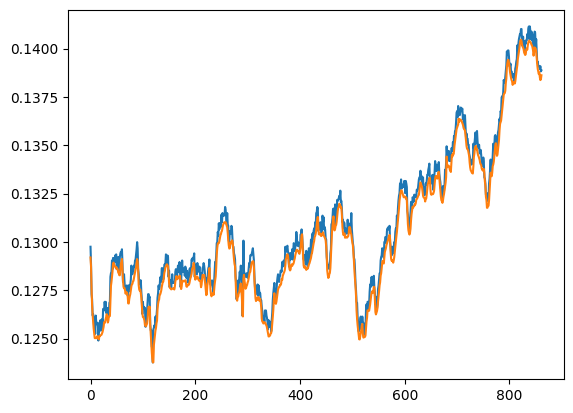

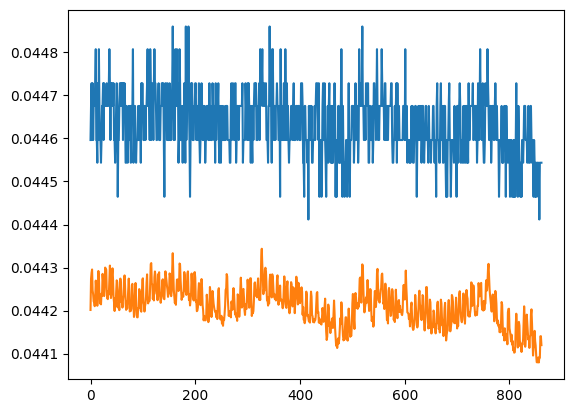

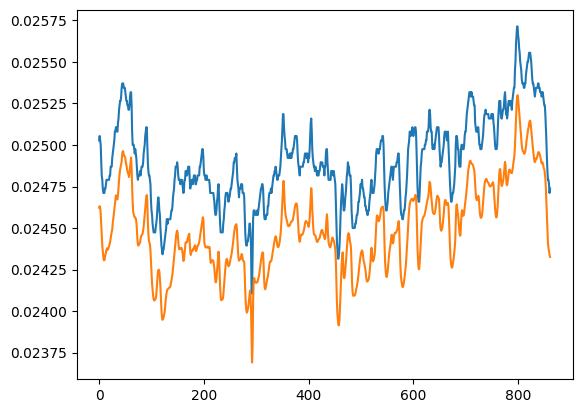

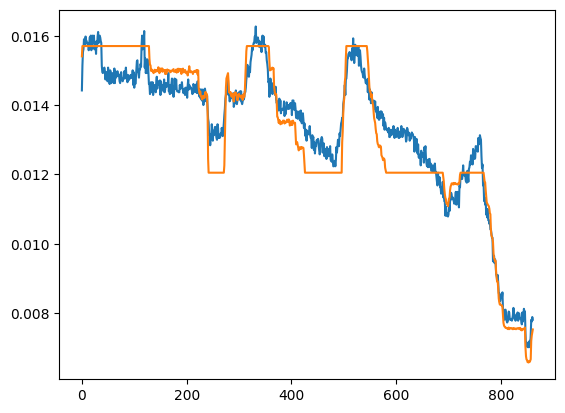

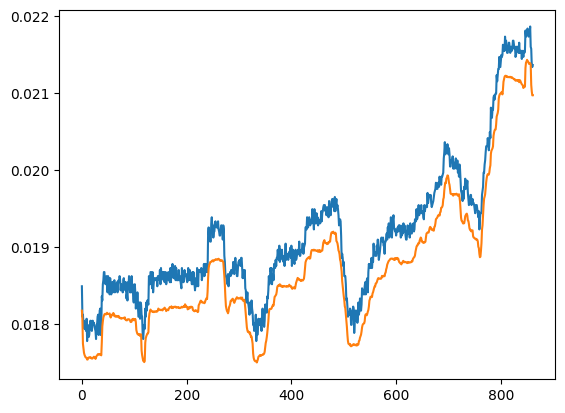

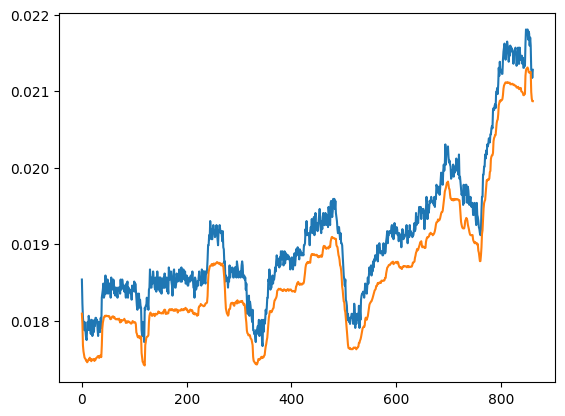

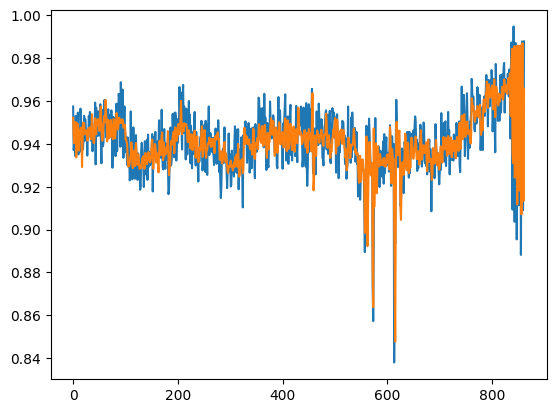

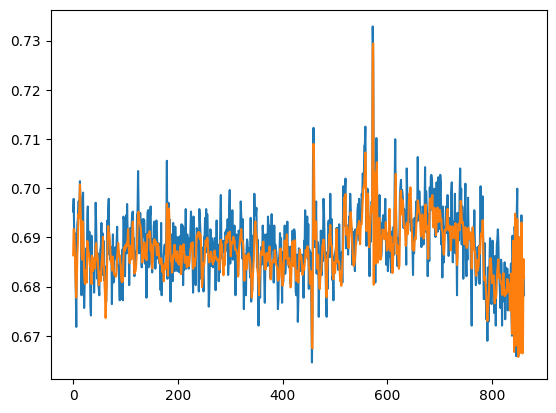

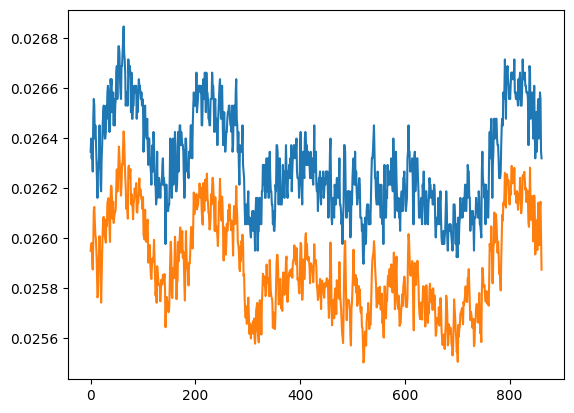

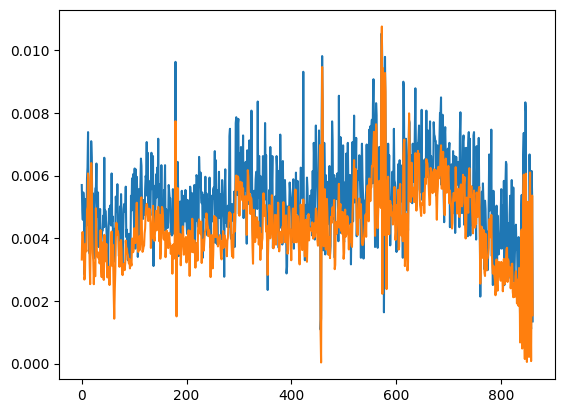

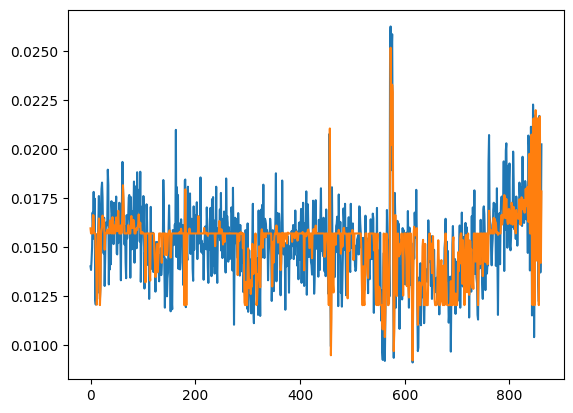

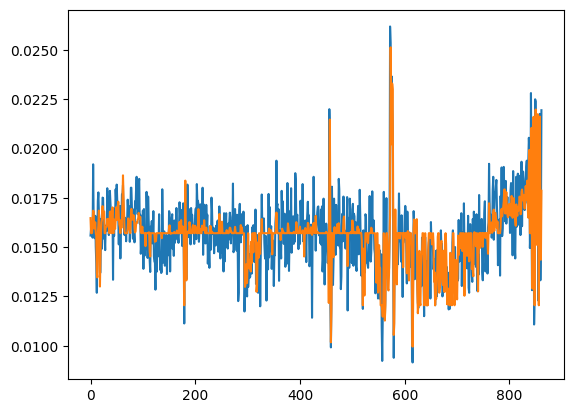

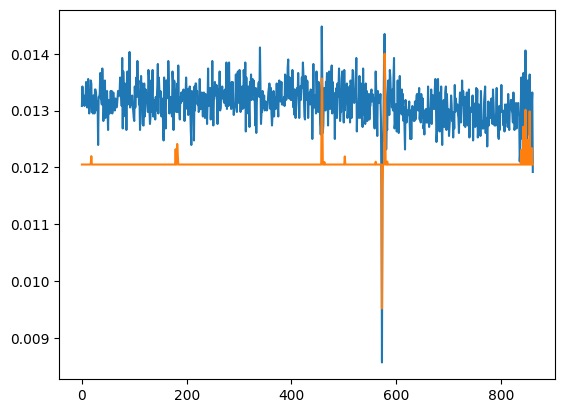

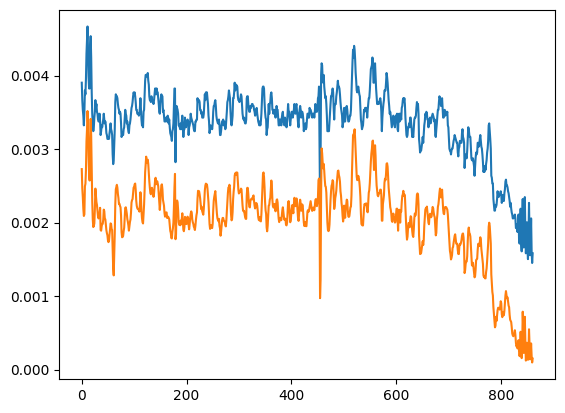

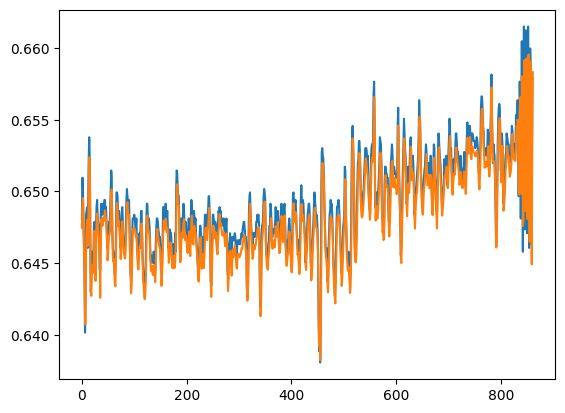

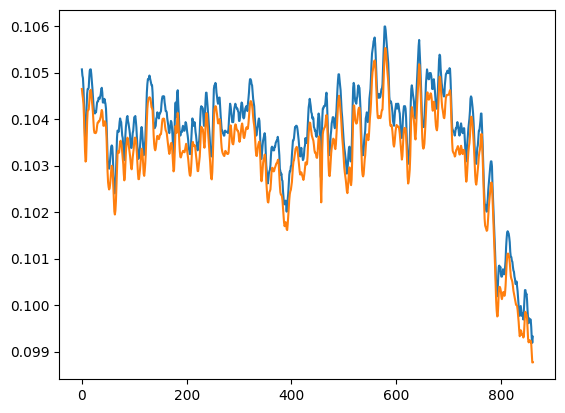

In [33]:
import matplotlib.pyplot as plt

for i in range(k):
    plt.plot(test_targets[1:,i])
    plt.plot(pred[1:,i])
    plt.show()